In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# https://quaternion.readthedocs.io/en/latest/
# conda install -c conda-forge quaternion
import quaternion

In [21]:
def skew_symm(a):
    return np.array([
        [0, -a[2], a[1]],
        [a[2], 0, -a[0]],
        [-a[1], a[0], 0]
    ])

def prepare_plot():
    # plot sphere
    # np.mgrid[start:end:x], if x is a complex number, 
    # it denotes the number of steps
    ax = plt.axes(projection='3d')
    ax.set_box_aspect([1, 1, 1])
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray", lw=0.5)
    return ax

## 随机构造 SO3

*Reference: 2018 ICML - Explorations in Homeomorphic Variational Auto-Encoding*

对于一个 $\mathrm{SO}(3)$，任意构造两行，推断出第三行。

$\mathcal{S}^2 \times \mathcal{S}^2 \rightarrow \mathrm{SO}(3)$

其中，

$\mathcal{S}^2 \equiv \{\|x\|=1, x\in \mathbb{R}^{n+1}\}$

*Reference: https://en.wikipedia.org/wiki/N-sphere*

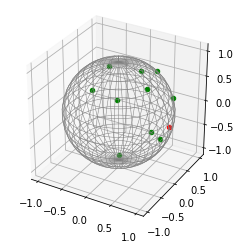

In [176]:
p = np.array([1., 0., 0.])

ax = prepare_plot()
ax.scatter3D([p[0]], [p[1]], [p[2]], c='r')

for _ in range(10):
    u = np.random.uniform(-1, 1, 3)
    u = u / np.linalg.norm(u)
    v = np.random.uniform(-1, 1, 3)
    v = v / np.linalg.norm(v)

    w1 = u
    w2 = v - np.dot(u, v) * u
    w2 = w2 / np.linalg.norm(w2)
    w3 = np.cross(w1, w2)
    w = np.array([w1, w2, w3])

    p2 = w @ p
    ax.scatter3D([p2[0]], [p2[1]], [p2[2]], c='g')


## SO3：李群、李代数

Rodrigues Formula：从李代数到李群 $\mathfrak{so}(3) \rightarrow \mathrm{SO}(3)$

任取一个 3-vector($\{\|x\|=1, x\in \mathbb{R}^3\}$)，构造 skew-symmetric matrix 得到一个 $\mathrm{SO}(3)$，旋转后得到的点在球上。

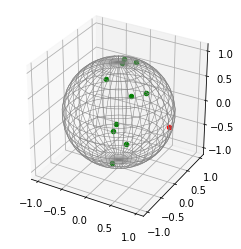

In [22]:
ax = prepare_plot()

x_i = np.array([1.0, 0.0, 0.0])

ax.scatter3D(x_i[0], x_i[1], x_i[2], color='r')

for i in range(10):
    w = np.random.randn(3)
    w = w / np.linalg.norm(w)
    R = skew_symm(w)
    x_wi = R @ x_i
    ax.scatter3D(x_wi[0], x_wi[1], x_wi[2], color='g')

右手定则，围绕 $\textbf{w}$ 逆时针旋转，通过李代数更新 3-vector。

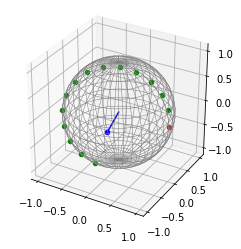

In [57]:
ax = prepare_plot()

x_i = np.array([1.0, 0.0, 0.0])

ax.scatter3D(x_i[0], x_i[1], x_i[2], color='r')

w = np.random.normal(size=3)
w = w / np.linalg.norm(w)

ax.plot3D([0, w[0]], [0, w[1]], [0, w[2]], color='b')
ax.scatter3D(w[0], w[1], w[2], color='b')

# Lie Algebra: I + sin t [w] + (1 - cos t) [w]^2
for i in range(1, 15):
    t = (2 * np.pi) * i / 20
    R = np.eye(3) + np.sin(t) * skew_symm(w) + (1 - np.cos(t)) * (skew_symm(w) @ skew_symm(w))
    x_wi = R @ x_i
    ax.scatter3D(x_wi[0], x_wi[1], x_wi[2], color='g')

从 $\mathrm{SO}(3)$ 到李代数：

*Reference: Lie Groups for 2D and 3D Transformations*

$$
\begin{aligned}
\mathbf{R} & \in \mathrm{SO}(3) \\
\theta & = \arccos \frac{\mathrm{tr}(\mathbf{R}) - 1}{2} \\
\ln \mathbf{R} & = \frac{\theta}{2\sin \theta} \cdot (\mathbf{R} - \mathbf{R}^\mathrm{T})
\end{aligned}
$$

李代数线性，但是不连续，会出现突变。

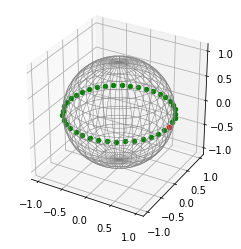

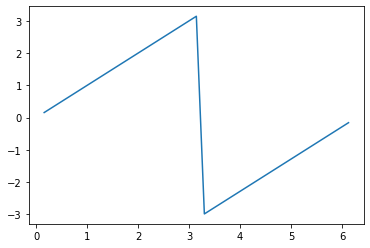

In [185]:
ax = prepare_plot()

x_i = np.array([1.0, 0.0, 0.0])

ax.scatter3D(x_i[0], x_i[1], x_i[2], color='r')

w = np.random.normal(size=3)
w = w / np.linalg.norm(w)

ts = []
results = []
for i in range(1, 40):
    t = (2 * np.pi) * i / 40
    R = np.array([
        [np.cos(t),  np.sin(t), 0],
        [-np.sin(t), np.cos(t), 0],
        [0, 0, 1]
    ])
    x_wi = R @ x_i
    ax.scatter3D(x_wi[0], x_wi[1], x_wi[2], color='g')

    theta = np.arccos((np.trace(R) - 1)/2)
    w2 = theta / (2 * np.sin(theta)) * (R - R.T)
    ts.append(t)
    results.append(w2[0][1])
plt.figure()
plt.plot(ts, results)

## 四元数

*Reference: https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation*

Given a vector,

$$
\mathbf{p} = p_x \mathbf{i} + p_y \mathbf{j} + p_z \mathbf{k}
$$

A rotation of angle $\theta$ around the **unit** axis $(u_x, u_y, u_z)$ can be represented by a quaternion:

$$
\mathbf{q} = \cos \frac{\theta}{2} + \sin \frac{\theta}{2} (u_x \mathbf{i} + u_y \mathbf{j} + u_z \mathbf{k})
$$

Note that the quaternion is a unit quaternion, whose inverse is its conjugate ($\mathbf{q}^{-1}=\mathbf{q}^*$).

The rotated vector is:
$$
\mathbf{p}' = \mathbf{q} \mathbf{p} \mathbf{q}^{-1}
$$

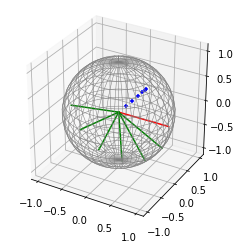

In [187]:
p = np.quaternion(0, 1, 0, 0)

ax = prepare_plot()
ax.plot3D([0, p.x], [0, p.y], [0, p.z], c='r')
    
for theta in np.arange(0.5, np.pi, 0.5):
    c, s = np.cos(theta / 2), np.sin(theta / 2)
    q = np.quaternion(c, 0, s, 0)
    p2 = q * p * q.conjugate()
    ax.scatter3D([q.x], [q.y], [q.z], c='b', marker='+')

    ax.plot3D([0, p2.x], [0, p2.y], [0, p2.z], c='g')